In [1]:
# 사용할 모듈 / 라이브러리 불러오기
import numpy as np 
import pandas as pd

import os
import zipfile
import cv2
import shutil 

import time
import copy
import torch
import torchvision

from torchvision import transforms, models
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# 예상 파일 경로 지정
print(os.listdir('../input'),'\n') 
with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_obj:
        zip_obj.extractall('/kaggle/working/') 
        
print(os.listdir('/kaggle/working/'))

data_root = '/kaggle/working/plates/' 
print(data_root)
print(os.listdir(data_root))

['platesv2'] 

['plates', '__MACOSX']
/kaggle/working/plates/
['.DS_Store', 'train', 'test']


In [3]:
## 배경 제거 및 크롭 기능 함수 모은 클래스 정의
class Remove_background_and_crop:
    
    # 탐지할 범위를 초기화하는 함수 
    def __init__(self, img):
        self.x00 = 0
        self.x00 = 0
        self.r00 = 0
        self.img = img
        self.mask = img
    
    # 이미지 크롭
    def crop(self): 
            c_r_crop = (1.42 * self.r00 / 2)
            self.img = self.img[int(self.y00) - int(c_r_crop) : int(self.y00) + int(c_r_crop), int(self.x00) - int(c_r_crop) : int(self.x00) + int(c_r_crop)]
            self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
            
            crop = self.img
            cv2.imwrite(image_folder,crop)
            h,w = self.img.shape[:2] 
            c = min(h, w)   
              
            for i in range (5, int(c/3), 5): 
                    crop_img = self.img[i : h-i, i : w-i]    
                    cv2.imwrite(image_folder[:-4] + '_Crop_' + str(i) + '.jpg', crop_img)
                    
            image1 = self.img[0 : int(h//2), 0 : int(w//2)]
            cv2.imwrite(image_folder[:-4] + 'image1' + '.jpg', image1)
            
            image2 = self.img[0 : int(h//2) : h, int(w//2) : w]
            cv2.imwrite(image_folder[:-4] + 'image2' + '.jpg', image2)
            
            image3 = self.img[int(h//2) : h, 0 : int(w//2)]
            cv2.imwrite(image_folder[:-4] + 'image3' + '.jpg', image3)
            
            image4 = self.img[0 : int(h//2), int(w//2) : w]
            cv2.imwrite(image_folder[:-4] + 'image4' + '.jpg', image4)
    
    # Crop() 함수 정상동작 확인
    def crop_test(self):
        c_r_crop = (1.42 * self.r00 / 2)
        self.img = self.img[int(self.y00) - int(c_r_crop) : int(self.y00) + int(c_r_crop), int(self.x00) - int(c_r_crop) : int(self.x00) + int(c_r_crop)]
        self.img = cv2.cvtColor(self.img, cv2. COLOR_BGR2RGB)
        cv2.imwrite(image_folder, self.img)       
    
    # 이미지 내에서 원의 여부를 체크하고, 있을 경우 원의 위치를 특정
    def find_circle(self):
        output = self.img.copy()    
        img = cv2.convertScaleAbs(self.img, alpha = 1.2, beta = 0.0)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 10, param1=10, param2=5, minRadius=40, maxRadius=250)
        
        if circles is not None: 
            print('중심점 좌표 출력:',self.x00,self.y00)
            circles = np.round(circles[0, :]).astype("int")
            print("중심점 좌표 및 지름 기반으로 작도 가능한 원: ")
            print(circles) 
                             
            for x, y, r in circles:
                if ((self.x00-15) < x < (self.x00+15)) and ((self.y00-15) < y < (self.y00+15)):
                    if r > self.r00: 
                        self.x00 = x
                        self.y00 = y
                        self.r00 = r
                        print('조건에 일치하는 변수: ', x, y, r)
                    
            if self.r00 == 0: 
                print('일치하는 접시 확인되지 않음','\n')
                ret,thresh = cv2.threshold(self.mask,235,255,0)
                contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)   
                c = max(contours, key=cv2.contourArea)
                (self.x00, self.y00), self.r00 = cv2.minEnclosingCircle(c)
            print('선택된 중심점 좌표:', self.x00, self.y00, self.r00)
    
    # 좌표 확인         
    def findCoordinates(self):  
        ret, thresh = cv2.threshold(self.mask,235,255,0)        
        M = cv2.moments(thresh)
        self.x00 = int(M["m10"] / M["m00"])
        self.y00 = int(M["m01"] / M["m00"])
    
    # 이미지 안에서 중심이 어딘지 확인    
    def findCenter(self):
        c_r_crop = 124
        self.img = self.img[int(self.y00) - int(c_r_crop) : int(self.y00) + int(c_r_crop), int(self.x00) - int(c_r_crop) : int(self.x00) + int(c_r_crop)]
    
    # 배경 삭제            
    def remove_background(self):  
        mainRectSize = .08
        fgSize = .01
        
        img = self.img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        new_h, new_w = img.shape[:2]
        mask = np.zeros(img.shape[:2], np.uint8)
        
        bg_w = round(new_w * mainRectSize)
        bg_h = round(new_h * mainRectSize)
        bg_rect = (bg_w, bg_h, new_w - bg_w, new_h - bg_h)
        
        fg_w = round(new_w * (1 - fgSize) / 2)
        fg_h = round(new_h * (1 - fgSize) / 2)
        fg_rect = (fg_w, fg_h, new_w - fg_w, new_h - fg_h)
        
        cv2.rectangle(mask, fg_rect[:2], fg_rect[2:4], color=cv2.GC_FGD, thickness=-1)
        bgdModel1 = np.zeros((1, 65), np.float64)
        fgdModel1 = np.zeros((1, 65), np.float64)
        
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 3, cv2.GC_INIT_WITH_RECT)
        cv2.rectangle(mask, bg_rect[:2], bg_rect[2:4], color=cv2.GC_PR_BGD, thickness=bg_w * 3)
        cv2.grabCut(img, mask, bg_rect, bgdModel1, fgdModel1, 10, cv2.GC_INIT_WITH_MASK)   
        
        mask_result = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')
        masked = cv2.bitwise_and(img, img, mask=mask_result)
        masked[mask_result < 2] = [255, 255, 255] 
        
        self.img = masked
        self.mask = mask_result

# 정의된 함수를 통해 이미지를 전처리하는 작업 진행 

## 더러운 접시 
for image_index in range (20):
    print ("'Dirty' 카테고리 내에서 처리 완료: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = '/kaggle/working/plates/train/dirty/{0:04}.jpg'.format(image_index) 
    img = cv2.imread(image_folder)
    
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()    
    
print ("\n\r", end="")    

# 깨끗한 접시
for image_index in range (20):
    print ("'Clean' 카테고리 내에서 처리 완료: ","{0:04}".format(image_index),"/0019", end="\r")
    image_folder = '/kaggle/working/plates/train/cleaned/{0:04}.jpg'.format(image_index) 
    img = cv2.imread(image_folder)
    
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop()
    
print ("\n\r", end="")

# 테스트용 이미지 
for image_index in range (744):
    print ("테스트 데이터 내에서 처리 완료: ","{0:04}".format(image_index),"/0743", end="\r")
    image_folder = '/kaggle/working/plates/test/{0:04}.jpg'.format(image_index) 
    img = cv2.imread(image_folder)
    
    out_img  = Remove_background_and_crop(img)
    out_img.remove_background()
    out_img.findCoordinates()
    out_img.find_circle()
    out_img.crop_test()
    
print ("\n\r", end="") 

Complete dirty:  0019 /0019
Complete cleaned:  0019 /0019
Complete test:  0743 /0743


In [4]:
train_dir = 'train' 
val_dir = 'val' 
class_names = ['cleaned', 'dirty']

# 파일 별 위치 탐지
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

# 파일 열어보기 (훈련용 파일)
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 276/276 [00:00<00:00, 9419.34it/s]


In [5]:
# pytorch 기반, transform 메소드 사용해 이미지 변환

## 학습용 데이터 
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.09, p=0.75, interpolation=3, fill=255),
    transforms.Resize((224, 224)),    
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## 검증용 데이터 
val_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.1, p=0.8, interpolation=3, fill=255),
    transforms.Resize((224, 224)),
    transforms.ColorJitter(hue=(-0.5,0.5)),
    transforms.RandomHorizontalFlip(),     
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])   

## 데이터 세트 전체 대상
dataset_transforms = {
                      'orig': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),

                      '140': transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '135': transforms.Compose([
    transforms.CenterCrop(135),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]), 
                      '130': transforms.Compose([
    transforms.CenterCrop(130),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '125': transforms.Compose([
    transforms.CenterCrop(125),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '120': transforms.Compose([
    transforms.CenterCrop(120),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '115': transforms.Compose([
    transforms.CenterCrop(115),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '110': transforms.Compose([
    transforms.CenterCrop(110),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '105': transforms.Compose([
    transforms.CenterCrop(105),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '100': transforms.Compose([
    transforms.CenterCrop(100),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                     '95': transforms.Compose([
    transforms.CenterCrop(95),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '90': transforms.Compose([
    transforms.CenterCrop(90),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '85': transforms.Compose([
    transforms.CenterCrop(85),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                       '80': transforms.Compose([
    transforms.CenterCrop(80),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
                      '75': transforms.Compose([
    transforms.CenterCrop(75),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),                                         
                       '70': transforms.Compose([
    transforms.CenterCrop(70),
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),                                                           
                     }
 
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16 
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [ ]:
# 입력받은 이미지가 어떤 내용인지 보여준다 
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy() 
    image = std * image + mean 
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.1)
 
X_batch, y_batch = next(iter(train_dataloader)) 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# 이미지를 출력하고, 이미지의 이름은 해당 파일의 이름으로 한다
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [7]:
# 모델 훈련 방법을 정의
def train_model(model, loss, optimizer, scheduler, num_epochs):
 
    # 손실 데이터 및 정확도 데이터 기록용 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
 
    for epoch in range(num_epochs):
        # 진행도 측정용 함수 
        print("Epoch {}/{}: ".format(epoch, num_epochs - 1), end="")
        
        # 훈련 단계이면 훈련을 진행, 훈련 단계가 아니면(끝났으면) 평가를 진행
        for phase in ['train', 'val']:
            if phase == 'train': 
                dataloader = train_dataloader 
                scheduler.step()
                model.train()  
            else: 
                dataloader = val_dataloader 
                model.eval()  
                
            running_loss = 0. 
            running_acc = 0.
 
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) 
                labels = labels.to(device) 
 
                # 모든 모델 패러미터 재료를 0으로 설정 (기존의 모델 패러미터가 새로운 모델 패러미터와 뒤섞이는 것을 미연에 방지)
                optimizer.zero_grad() 
 
                with torch.set_grad_enabled(phase == 'train'): 
                    preds = model(inputs) 
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1) 
                
                    # 훈련 단계일 때만 재료들을 최적화기에 넘긴다 
                    if phase == 'train':
                        loss_value.backward() 
                        optimizer.step() # 다음 번 절차로
 
                running_loss += loss_value.item() 
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  
 
            epoch_loss = running_loss / len(dataloader)  
            epoch_acc = running_acc / len(dataloader)
            
            print("{} Loss: {:.4f} Acc: {:.4f} ".format(phase, epoch_loss, epoch_acc), end="")
            
            # 손실과 정확도 역사에 현재 epoch의 손실, 정확도를 기록
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
        
    return model, loss_hist, acc_hist

In [ ]:
# 이미 훈련된 모델 불러오기 
model = models.resnet152(pretrained=True) 

for param in model.parameters(): 
   param.requires_grad = False 

# cuda가 사용 가능할 때는 cuda 사용하고, 그렇지 않을 때는 cpu를 사용 
model.fc = torch.nn.Linear(model.fc.in_features, 2) 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 최적화기와 게획기 정의, 호출
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=0.001) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [9]:
# 훈련 이행
model, loss, acc = train_model(model, loss, optimizer, scheduler, num_epochs=30); 

/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/29 [00:00<?, ?it/s]

Epoch 0/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.5651 Acc: 0.6940 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.4257 Acc: 0.8191 Epoch 1/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4130 Acc: 0.8233 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.3286 Acc: 0.8864 Epoch 2/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4423 Acc: 0.7608 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.3184 Acc: 0.8504 Epoch 3/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2924 Acc: 0.8922 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2261 Acc: 0.9271 Epoch 4/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.3116 Acc: 0.8664 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2744 Acc: 0.8807 Epoch 5/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.4336 Acc: 0.8147 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2899 Acc: 0.8864 Epoch 6/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2814 Acc: 0.8772 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2576 Acc: 0.8807 Epoch 7/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2660 Acc: 0.8987 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2222 Acc: 0.9328 Epoch 8/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2289 Acc: 0.9073 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2132 Acc: 0.9536 Epoch 9/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2588 Acc: 0.9181 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2452 Acc: 0.8655 Epoch 10/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2460 Acc: 0.9095 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2598 Acc: 0.8968 Epoch 11/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2601 Acc: 0.8987 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2184 Acc: 0.9432 Epoch 12/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2499 Acc: 0.8922 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2614 Acc: 0.9072 Epoch 13/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2839 Acc: 0.8772 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2711 Acc: 0.8920 Epoch 14/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2597 Acc: 0.8987 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.1861 Acc: 0.9583 Epoch 15/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2457 Acc: 0.9052 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2987 Acc: 0.8864 Epoch 16/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2276 Acc: 0.9073 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2401 Acc: 0.8920 Epoch 17/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2780 Acc: 0.8901 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2689 Acc: 0.8968 Epoch 18/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2928 Acc: 0.8987 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2757 Acc: 0.8807 Epoch 19/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2739 Acc: 0.8793 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2574 Acc: 0.8807 Epoch 20/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2337 Acc: 0.9159 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2003 Acc: 0.9688 Epoch 21/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2392 Acc: 0.9203 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2671 Acc: 0.9015 Epoch 22/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2765 Acc: 0.8772 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2476 Acc: 0.9119 Epoch 23/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2714 Acc: 0.8772 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2291 Acc: 0.9271 Epoch 24/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2475 Acc: 0.8879 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.3177 Acc: 0.8409 Epoch 25/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2588 Acc: 0.8966 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2538 Acc: 0.8655 Epoch 26/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2408 Acc: 0.9095 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2809 Acc: 0.8551 Epoch 27/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2458 Acc: 0.9181 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2570 Acc: 0.8920 Epoch 28/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2430 Acc: 0.9203 

  0%|          | 0/29 [00:00<?, ?it/s]

val Loss: 0.2638 Acc: 0.8911 Epoch 29/29:

  0%|          | 0/6 [00:00<?, ?it/s]

train Loss: 0.2555 Acc: 0.9009 

100%|██████████| 6/6 [00:01<00:00,  5.12it/s]

val Loss: 0.2450 Acc: 0.9119 

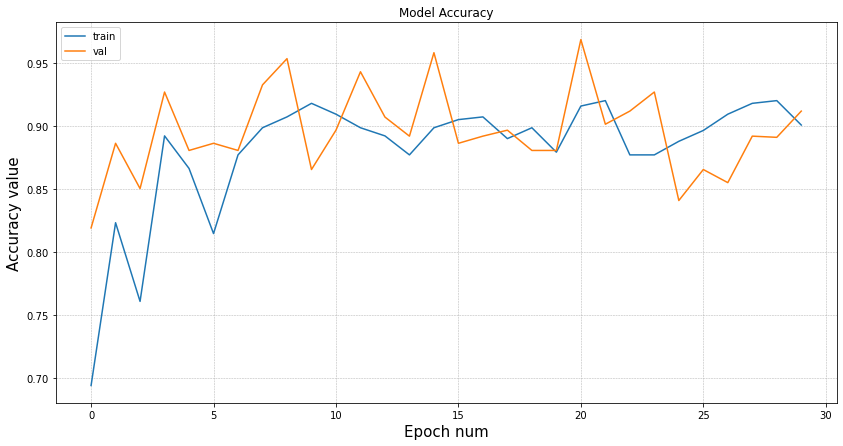

In [10]:
plt.rcParams['figure.figsize'] = (14, 7)

for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
    
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

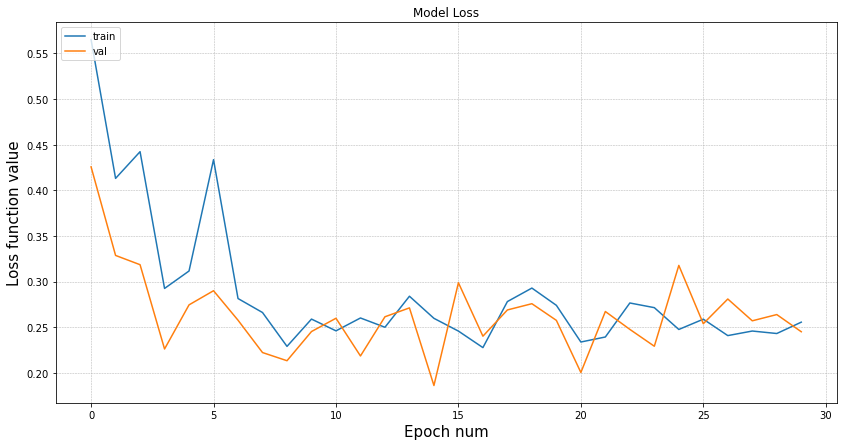

In [11]:
plt.rcParams['figure.figsize'] = (14, 7)

for experiment_id in loss.keys():
    plt.plot(loss[experiment_id], label=experiment_id)
    
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')

In [12]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [13]:
# 훈련된 결과 기반으로 사후 정확도 추적
class ImageFolderWithPaths(torchvision.datasets.ImageFolder): 
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index) 
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
df = pd.DataFrame
for (i,tranforms) in dataset_transforms.items():
    test_dataset = ImageFolderWithPaths('/kaggle/working/test', tranforms) 
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=0) 
    
    model.eval() 
    test_predictions = [] 
    test_img_paths = [] 
    
    for inputs, labels, paths in tqdm(test_dataloader): 
        inputs = inputs.to(device) 
        labels = labels.to(device)  
        with torch.set_grad_enabled(False):
            preds = model(inputs) 
        test_predictions.append(
            torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()) 
        test_img_paths.extend(paths)
    test_predictions = np.concatenate(test_predictions)
    
    submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
    submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
    submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
    submission_df.set_index('id', inplace=True)
    
    try:
        df = df.merge(submission_df, how='inner', on='id') 
    except BaseException: 
        df = submission_df 
    # 최종 제출용 파일로 가공하는 과정    
    submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
    submission_df.to_csv('submission_predict_{0}.csv'.format(i))
df.head(8)

100%|██████████| 47/47 [00:04<00:00, 10.74it/s]


,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y,label_x,label_y
id,,,,,,,,,,,,,,,,
0000,0.995830,0.999218,0.998898,0.998864,0.997169,0.998322,0.996839,0.995076,0.994821,0.996963,0.996631,0.995330,0.995825,0.998054,0.998804,0.997197
0001,0.945821,0.950359,0.925045,0.978310,0.985180,0.990101,0.991954,0.994544,0.984038,0.980005,0.995474,0.990533,0.992570,0.977330,0.982622,0.978393
0002,0.473196,0.368584,0.493812,0.546605,0.736877,0.579901,0.587146,0.842231,0.882848,0.784069,0.490308,0.737313,0.787854,0.831962,0.747609,0.769783
0003,0.981963,0.722954,0.727964,0.981963,0.975439,0.963164,0.956525,0.949029,0.977652,0.972819,0.975720,0.997425,0.995946,0.993480,0.987997,0.992370
0004,0.609147,0.623411,0.660393,0.862999,0.829403,0.787672,0.841473,0.865134,0.851203,0.914764,0.898640,0.952944,0.960818,0.978729,0.991480,0.981501
0005,0.694705,0.331087,0.255687,0.307201,0.476474,0.602656,0.823338,0.742000,0.907696,0.937461,0.946330,0.979867,0.945408,0.772531,0.884179,0.808847
0006,0.985967,0.989116,0.943185,0.944787,0.956916,0.895553,0.947667,0.984623,0.979605,0.992508,0.994088,0.998072,0.996738,0.997650,0.994429,0.996359
0007,0.916422,0.914093,0.948553,0.963006,0.984976,0.956589,0.983530,0.975789,0.985558,0.979924,0.941740,0.930319,0.946599,0.958685,0.959065,0.973224


In [14]:
df['mean'] = df.mean(axis=1)
df.drop(df.columns[:-1], axis='columns', inplace=True)
df['label'] = df['mean'].map(lambda pred: 'dirty' if pred > 0.50 else 'cleaned')
df.drop(df.columns[:-1], axis='columns', inplace=True)
df.head(10)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty
0006,dirty
0007,dirty
0008,dirty


In [15]:
df.to_csv('submission.csv')